In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import itertools
import scipy as sp
from scipy import linalg
import matplotlib as mpl

from itertools import product
from scipy import stats
%matplotlib inline

In [2]:
df = pd.read_csv('data/Torschlag_Trafo_07122015_to_11122015.csv', sep=',')

In [3]:
X = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

# Data Smoothing

In [4]:
r = X.rolling(60).mean()

In [5]:
data_smooth = pd.DataFrame(r.iloc[59:,:])

In [6]:
data_smooth.shape

(380589, 9)

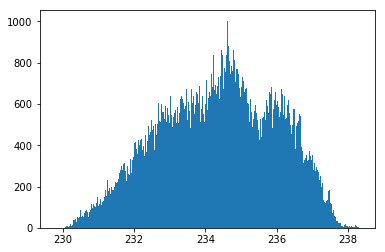

In [7]:
plt.hist(data_smooth.iloc[:,0],bins=1000)
plt.show()

# End of Data Smoothing

In [8]:
#PCA Implementation
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_smooth)

X_non_smoothed = StandardScaler().fit_transform(X)

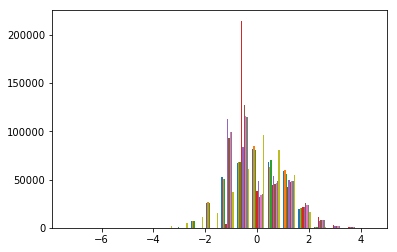

In [9]:
plt.hist(X_non_smoothed,bins=20)
plt.show()

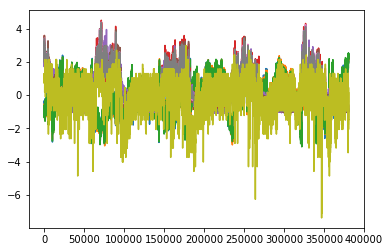

In [10]:
plt.plot(X_non_smoothed)
plt.show()

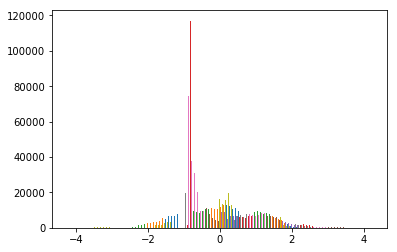

In [11]:
plt.hist(X_std,bins=100)
plt.show()

In [12]:
X_std[1000]

array([-0.81479743, -0.91980114, -0.94375773,  0.81415447,  1.01030995,
        1.22427872,  1.08495911,  1.03381005,  1.29075557])

In [13]:
#Calculate the z-score of all the points
from scipy import stats
zscore = stats.zscore(X)

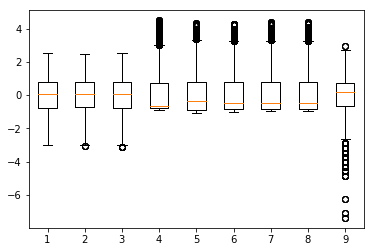

In [14]:
plt.boxplot(zscore)
plt.show()

In [15]:
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=9)
Y_sklearn = sklearn_pca.fit_transform(X_std)

sklearn_pca.explained_variance_ratio_.cumsum()

array([ 0.6907856 ,  0.91388265,  0.99021535,  0.99575275,  0.99890289,
        0.99953083,  0.99994913,  0.99999627,  1.        ])

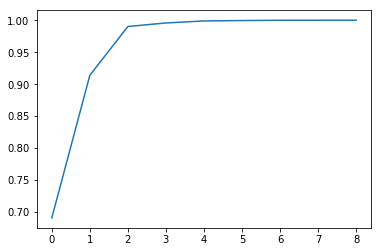

In [16]:
plt.plot(sklearn_pca.explained_variance_ratio_.cumsum())

In [17]:
#Convert the PCA to dataframe
data = pd.DataFrame(Y_sklearn[:,0:3], columns=('PCA1', 'PCA2','PCA3'))
data.head()



,PCA1,PCA2,PCA3
0,6.478272,-2.004349,0.832634
1,6.482626,-2.000501,0.826960
2,6.483993,-1.996518,0.826020
3,6.485360,-1.992535,0.825080
4,6.486727,-1.988552,0.824139


/home/arun/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


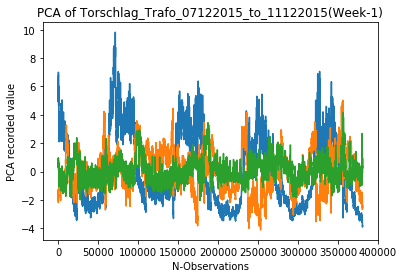

In [18]:
#Plot the PCA values
fig = plt.figure() 
plt.legend(loc='upper right')
plt.plot(data)
plt.title("PCA of Torschlag_Trafo_07122015_to_11122015(Week-1)")

#plt.legend()
plt.ylabel("PCA recorded value")
plt.xlabel("N-Observations")

# Split the data into training and testing 

In [19]:
def split_data(data, val_size=0.1, test_size=0.2):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    return df_train, df_val, df_test

In [20]:
train, validate, test = split_data(data)

# Splitting data ends

# Method 1 : Choose the best model

In [21]:
#Fit GMM on the PCA
from sklearn.mixture import GaussianMixture
import pylab as pl

def model_fit_1():
    n_components = np.arange(0, 20)
    BIC = np.zeros(n_components.shape)
    AIC = np.zeros(n_components.shape)
    for i, n in enumerate(n_components):
        clf = GaussianMixture(n_components=n, covariance_type='full')
        clf.fit(train)
        AIC[i] = clf.aic(train)
        BIC[i] = clf.bic(train)
    pl.figure()
    pl.plot(n_components, AIC, label='AIC')
    pl.plot(n_components, BIC, label='BIC')
    pl.legend(loc=0)
    pl.xlabel('n_components')
    pl.ylabel('AIC / BIC')
    return clf, AIC, BIC

In [22]:
def gmm_ad(wgt_log_probability):
    values = []
    index = []
    threshold = 3 * wgt_log_probability.std() #Check if we can consider since its not a normal distribution
    a = np.absolute(wgt_log_probability.mean()) + threshold
    count = 0
    for i in range(0,len(wgt_log_probability)):
        #print i
        if np.absolute(wgt_log_probability[i]) > a:
            count = count + 1
            values.append(wgt_log_probability[i])
            index.append(i)
    return count, values, index
    #print values

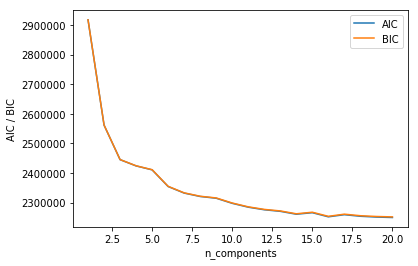

In [23]:
clf, clf_aic, clf_bic  = model_fit_1()

In [24]:
clf.weights_ #the weights of no_of_components, see first parameter to GaussianMixture

array([ 0.05286087,  0.10407242,  0.08784436,  0.03677264,  0.04771816,
        0.05295294,  0.02933612,  0.08864353,  0.01285142,  0.0192736 ,
        0.01635349,  0.0253728 ,  0.03823233,  0.01827275,  0.03540944,
        0.04481714,  0.06546006,  0.08006035,  0.0489013 ,  0.09479428])

In [25]:
clf.means_.shape #(n_components, n_features)

(20, 3)

The precision matrices for each component in the mixture. **A precision matrix is the inverse of a covariance matrix.** A covariance matrix is symmetric positive definite so the mixture of Gaussian can be equivalently parameterized by the precision matrices. Storing the precision matrices instead of the covariance matrices makes it more efficient to compute the log-likelihood of new samples at test time. The shape depends on covariance_type:

In [26]:
clf.covariances_.shape #(n_components, n_features, n_features) if 'full'

(20, 3, 3)

In [27]:
clf.precisions_.shape #

(20, 3, 3)

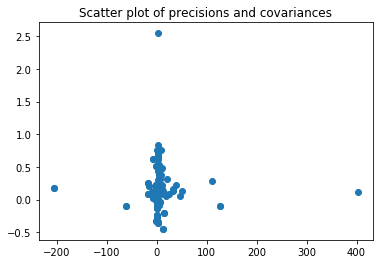

In [28]:
plt.scatter(clf.precisions_, clf.covariances_)
plt.title('Scatter plot of precisions and covariances')

In [29]:
classes = clf.predict(test)
classes

array([ 1,  1,  1, ..., 19, 19, 19])

In [30]:
np.unique(classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

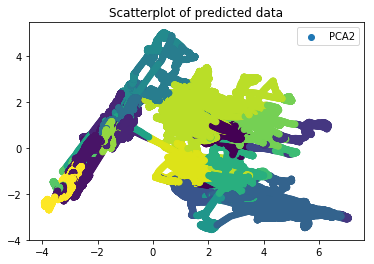

In [31]:
classes = clf.predict(test)
plt.scatter(test.iloc[:,0], test.iloc[:,1], c=classes)
plt.legend()
plt.title('Scatterplot of predicted data')
plt.show()

In [32]:
score_samp = clf.score_samples(train) #Compute the weighted log probabilities for each sample.

In [80]:
np.savetxt("Original_data.txt",score_samp)

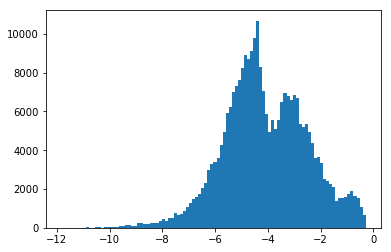

In [86]:
plt.hist(score_samp,bins =100)
plt.show()

In [107]:
#http://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

Testing if a data sample is normally distribution can be done in a lot of ways. One simple method is with a QQ plot. To do this, use 'qqplot(X)' where X is your data sample. If the result is approximately a straight line, the sample is normal. If the result is not a straight line, the sample is not normal.

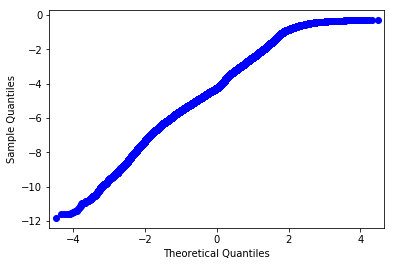

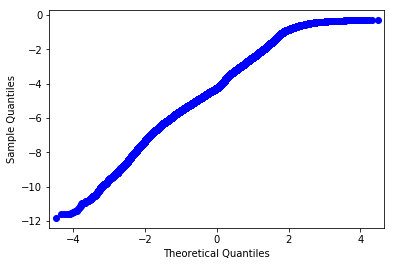

In [111]:
import statsmodels.api as sm
sm.qqplot(score_samp)

In [108]:
ss_mean, ss_m_minus_h, ss_m_plus_h = mean_confidence_interval(score_samp)
ss_mean, ss_m_minus_h, ss_m_plus_h

(-4.1041313859797715, -4.1119542949365409, -4.096308477023002)

In [96]:
def count_no_of_points(dist,filename):
    count = 0
    anomalous_values = []
    for i in dist:
        if i < -10:
            count += 1
            anomalous_values.append(i)
    np.savetxt(filename,anomalous_values)
    return count

In [97]:
less_probable_value_count = count_no_of_points(score_samp,"training_1.txt")
less_probable_value_count

Calculate the number of data points lower than -10

In [57]:
score_samp_test = clf.score_samples(test)

In [62]:
score_samp_test.shape

(76118,)

In [75]:
def outlier_points(x,percent):
    x_sorted = np.sort(np.absolute(x))
    percent = percent
    p = int(round(len(x) * percent))
    return (x_sorted[:p])

In [82]:
predicted_anomalies = outlier_points(score_samp,0.01)
count = len(predicted_anomalies)
count

2740

In [81]:
np.savetxt("Anomaly_points.txt",predicted_anomalies)

In [78]:
predicted_anomalies_test = outlier_points(score_samp_test,0.0001)
count_test = len(predicted_anomalies_test)
count_test

8

In [79]:
predicted_anomalies_test

array([ 0.39014708,  0.39056204,  0.39072755,  0.39223334,  0.39225898,
        0.39454802,  0.39690597,  0.39770362])

In [ ]:
import random
random_score_sample = random.sample(np.absolute(score_samp),100)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

((array([-4.56232528, -4.37255779, -4.26964366, ...,  4.26964366,
          4.37255779,  4.56232528]),
  array([-11.83317813, -11.62735615, -11.61448191, ...,  -0.29719775,
          -0.29711888,  -0.29702722])),
 (1.584589155154047, -4.1041313859797706, 0.99670694943539906))

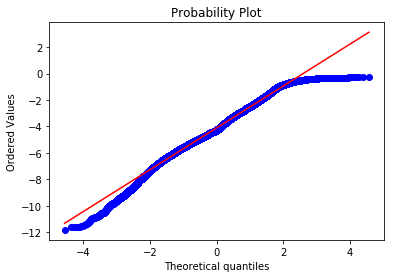

In [56]:
stats.probplot(score_samp, plot=plt)

((array([-4.28575019, -4.08431271, -3.97465167, ...,  3.97465167,
          4.08431271,  4.28575019]),
  array([-23.4158344 , -23.40889692, -23.38654281, ...,  -0.39072755,
          -0.39056204,  -0.39014708])),
 (2.1293250219741244, -4.6438903221499093, 0.92754533775724379))

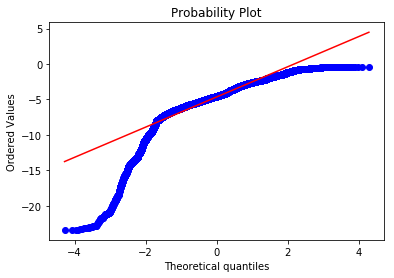

In [59]:
stats.probplot(score_samp_test, plot=plt)

In [39]:
print("Score sample values:")
print("Min value : %s " % score_samp.min())
print("Max value : %s " % score_samp.max())
print("Mean value : %s " % score_samp.mean())
print("Median value : %s " % np.median(score_samp))
print("Standard Deviation value : %s " % score_samp.std())

Score sample values:
Min value : -11.8331781306 
Max value : -0.297027223351 
Mean value : -4.10413138598 
Median value : -4.26248456751 
Standard Deviation value : 1.58979702366 


In [40]:

pdf = stats.norm.pdf(score_samp)
pdf[0:5]

array([  3.44480523e-15,   4.05703706e-15,   4.61240663e-15,
         5.24256499e-15,   5.95736612e-15])

In [41]:
print("Score sample values:")
print("Min value : %s " % pdf.min())
print("Max value : %s " % pdf.max())
print("Mean value : %s " % pdf.mean())
print("Median value : %s " % np.median(pdf))
print("Standard Deviation value : %s " % pdf.std())

Score sample values:
Min value : 1.56697500876e-31 
Max value : 0.381726414676 
Mean value : 0.0209996093684 
Median value : 4.52491859918e-05 
Standard Deviation value : 0.0624487844025 


In [42]:
no_of_anomalies, wgt_log_prob, position = gmm_ad(score_samp)
no_of_anomalies

1171

In [ ]:
position

In [44]:
anom_points = []
for i in position:
    anom_points.append(Y_sklearn[i])


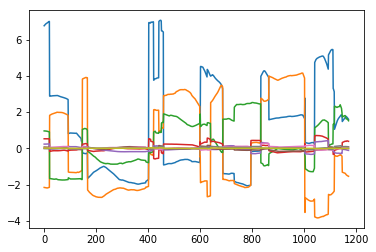

In [45]:
plt.plot(anom_points)
plt.show()

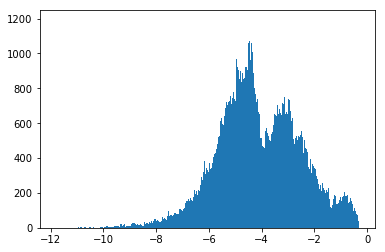

In [47]:
plt.hist(score_samp,bins=1000)
plt.show()

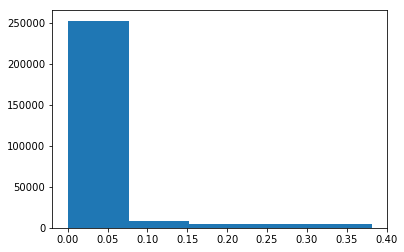

In [48]:
plt.hist(pdf,bins=5)
plt.show()

# Method 2 : Choose the best model

def best_fit(X, n_components=20, **kwargs):
    """
    Find best fitting by Gaussian Mixture Model
    Arguments:
        X -- data points
        n_components -- maximum number of mixture components
    Returns:
        A list of GMM instance and BICs of each fitting tried
    """
    # create several GMM instance with different covariance_type
    COVARIANCE_TYPES = ['spherical', 'tied', 'diag', 'full']
    properties = list(product(COVARIANCE_TYPES, range(1, n_components+1)))
    models = np.zeros(len(properties), dtype=object)
    for i, (covariance_type, n_component) in enumerate(properties):
        models[i] = GaussianMixture(n_component, covariance_type=covariance_type, **kwargs)
        models[i].fit(X)
    # calculate AIC/BIC
    AIC = np.array([m.aic(X) for m in models])
    BIC = np.array([m.bic(X) for m in models])
    # find best model by AIC
    best_model = models[np.argmin(AIC)]
    return best_model, AIC, BIC

best_model, AIC, BIC = best_fit(train)

n_components = np.arange(1, 21)
#BIC = np.zeros(n_components.shape)
#AIC = np.zeros(n_components.shape)
COVARIANCE_TYPES = ['spherical', 'tied', 'diag', 'full']
a = 0
b = 20
for i in COVARIANCE_TYPES:
    pl.figure()
    pl.plot(n_components, AIC[a:b], label='AIC')
    pl.plot(n_components, BIC[a:b], label='BIC')
    pl.legend(loc=0)
    pl.xlabel('n_components')
    pl.ylabel('AIC / BIC of %s'%i)
    a = b
    b = b+20

# Test With Obvious anomalies

test = pd.read_csv('data/Test_obvious_anomaly.csv', sep=',')

r = test.rolling(60).mean()
data_smooth_test = pd.DataFrame(r.iloc[59:,:])

plt.hist(data_smooth_test.iloc[:,0],bins=1000)
plt.show()

test_std = StandardScaler().fit_transform(data_smooth_test)

test_non_smoothed = StandardScaler().fit_transform(test)

plt.hist(test_std,bins=100)
plt.show()

sklearn_pca = PCA(n_components=9)
Y_sklearn_test = sklearn_pca.fit_transform(test_std)

data_test = pd.DataFrame(Y_sklearn_test, columns=('PCA1', 'PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9'))
data_test.head()

classes_test = clf.predict(data_test)
classes_test

score_samp_test = -clf.score_samples(Y_sklearn_test)
no_of_anomalies, wgt_log_prob = gmm_ad(score_samp_test)

score_samp_test.shape

plt.hist(score_samp_test,bins=1000)
plt.show()

no_of_anomalies, wgt_log_prob

clf.score(test.iloc[17,:].reshape(1,-1))

clf.score_samples(test.iloc[17,:].reshape(1,-1))

# Test With Obvious anomalies Ends